In [1]:
from ema_workbench import load_results
from ema_workbench.analysis import feature_scoring

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pickle

from collections import Counter

import gmatch4py as gm

C:\Users\IvS\anaconda3\envs\calibration_1_py9\lib\site-packages\ema_workbench\em_framework\__init__.py:101: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEvaluator not available")
<frozen importlib._bootstrap>:228: UserWarning: To obtain optimal results install the Cython 'munkres' module at  https://github.com/jfrelinger/cython-munkres-wrapper


In [4]:
#Add GT
experiments, outcomes = load_results("Results_EMA_Graph_Graph_Structure.tar.gz")
del experiments["policy"]
del experiments["scenario"]
del experiments["model"]

In [5]:
experiments

,graph_idx
0,39815
1,15404
2,19851
3,15547
4,21748
...,...
9995,11583
9996,31255
9997,3620
9998,20770


In [6]:
with open(r"../dec_var_qd_density_40000_cnhk_usa.pkl", "rb") as f:
    graphs = pickle.load(f)

In [7]:
# Set attributes of graphs as part of the experiment
for i, row in experiments.iterrows():
    idx = row["graph_idx"]
    experiments.loc[i, "#vertices"] = graphs[idx]["nodes"]
    experiments.loc[i, "#edges"] = graphs[idx]["edges"]
    experiments.loc[i, "density"] = graphs[idx]["density"]

    node_types = [data.get('node_type') for _, data in graphs[idx]["graph"].nodes(data=True)]
    type_counts = Counter(node_types)
    for node_type, count in type_counts.items():
        experiments.loc[i, node_type] = count

In [8]:
experiments.rename(columns=lambda x: x.replace('wholesales_', 'warehouse_'), inplace=True)
experiments.rename(columns=lambda x: x.replace('large_retailer', 'distributor'), inplace=True)
experiments.rename(columns=lambda x: x.replace('small_retailer', 'hospital'), inplace=True)

In [9]:
experiments

,graph_idx,#vertices,#edges,density,supplier,manufacturer,warehouse_consolidator,hospital,end_customer,warehouse_distributor,distributor,export_port,transit_port,import_port
0,39815,42.0,129.0,0.074913,2.0,3.0,4.0,3.0,1.0,1.0,1.0,9.0,9.0,9.0
1,15404,70.0,189.0,0.039130,1.0,2.0,2.0,8.0,1.0,3.0,1.0,8.0,29.0,15.0
2,19851,87.0,309.0,0.041299,1.0,4.0,6.0,1.0,1.0,2.0,1.0,17.0,36.0,18.0
3,15547,50.0,96.0,0.039184,2.0,4.0,2.0,4.0,1.0,3.0,2.0,3.0,19.0,10.0
4,21748,78.0,254.0,0.042291,2.0,2.0,9.0,10.0,1.0,1.0,4.0,13.0,27.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,11583,85.0,266.0,0.037255,1.0,3.0,6.0,6.0,1.0,2.0,10.0,16.0,26.0,14.0
9996,31255,64.0,196.0,0.048611,3.0,3.0,3.0,10.0,1.0,5.0,3.0,10.0,17.0,9.0
9997,3620,103.0,341.0,0.032458,4.0,3.0,7.0,2.0,1.0,1.0,4.0,16.0,48.0,17.0
9998,20770,60.0,148.0,0.041808,2.0,5.0,5.0,9.0,1.0,1.0,4.0,12.0,17.0,4.0


In [10]:
# Add graph edit distance to outcome
gt_graph = [v["graph"] for k,v in graphs.items() if v["hash"]=="ground_truth"][0]

In [11]:
def calculate_ged(gt, sol):
    # calculate graph edit distance
    ged=gm.GraphEditDistance(1,1,1,1) # all edit costs are equal to 1
    result=ged.compare([gt, sol],None) 
        
    #distance = ged.distance(result)[1][0]
    distance = np.sum(result)

    return distance

In [12]:
#Calculate GED and add as outcome
all_ged = np.array([calculate_ged(gt_graph, graphs[row["graph_idx"]]["graph"]) for _, row in experiments.iterrows()])
outcomes["graph edit distance"] = all_ged

outcomes["L1 distance"] = outcomes.pop("total_distance")
outcomes["kpi transport cost"] = outcomes.pop("transport_cost")

del graphs

#Fill na
experiments = experiments.fillna(0)

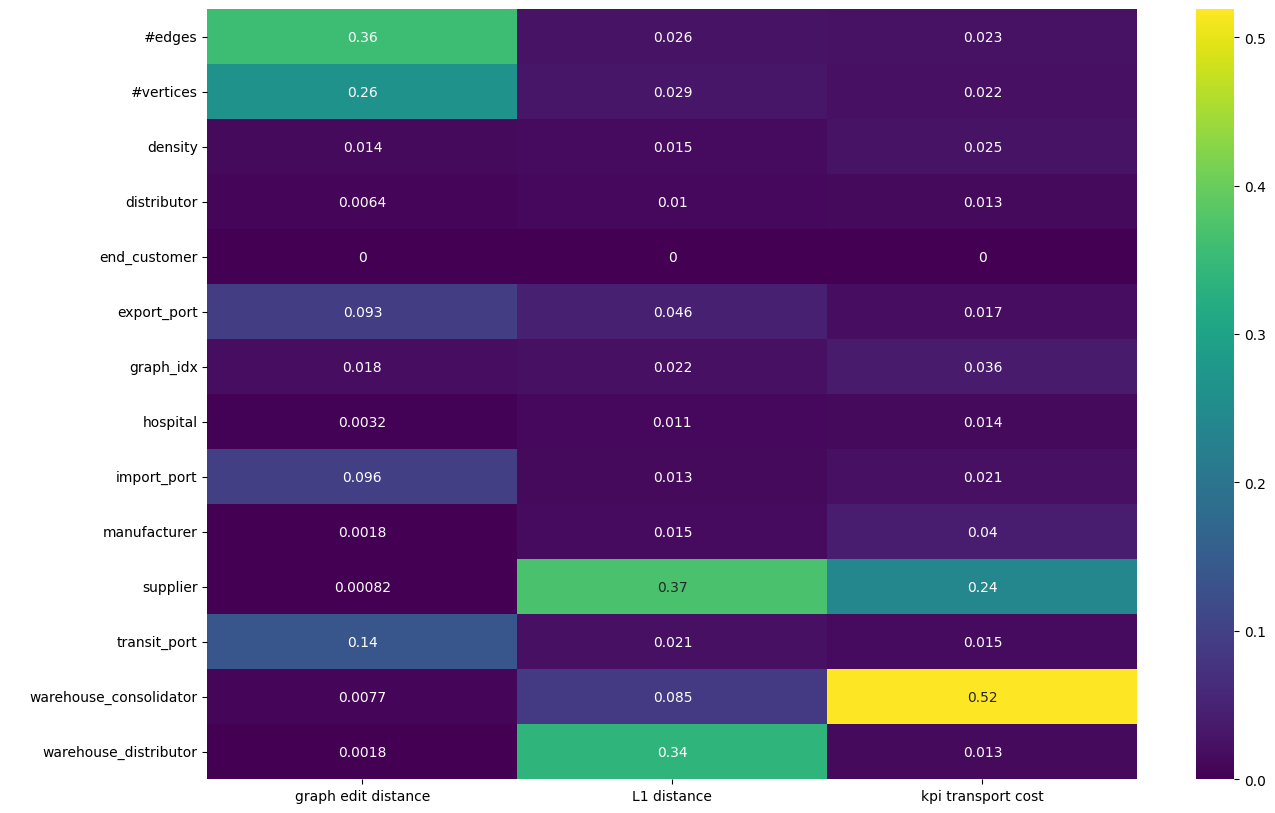

In [13]:
#Plot
plt.figure(figsize=(15, 10))
#plt.title(f"Feature scoring for structure")
fs = feature_scoring.get_feature_scores_all(experiments, outcomes)
sns.heatmap(fs, cmap="viridis", annot=True)
plt.ylabel(" ")
plt.savefig("./images/feature_scoring_only_structure_2.png", bbox_inches='tight')
plt.show()